Build binary classifier model to predict the flight will be on-time or late
Download data from microsoft site

In [3]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0  2997k      0 --:--:-- --:--:-- --:--:-- 3003k


In [4]:
#import data and preview 5 rows
import pandas as pd
df = pd.read_csv('flightdata.csv')
df.head()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [5]:
df.shape

(11231, 26)

In [6]:
#check is there any null value
df.isnull().values.any()

True

In [7]:
#null value summary
df.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

The column unnameyd was mistakenly created -> drop this column

In [8]:
df = df.drop('Unnamed: 25',axis=1)
df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

Get the columns needed for model

In [9]:
selected_columns = ["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]
df = df[selected_columns]
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

The column contains missing values is ARR_DEl15, which uses 0ss to identify flights that arrived on time and 1s for flight that didn't.


In [10]:
#show first 5 rows with missing value
df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


The missing value in ARR_DEL15 indicate that the flight wass canceled or diverted. I consider that mean "late" and will fill that missing with 1 (late) using df.fillna

In [11]:
df = df.fillna({'ARR_DEL15':1})
#show the row 177 TO 184 that N/a values were replace with 1
df.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


Binning CRS_DEP_TIME into 24 bin

In [12]:
import math
for index,row in df.iterrows():
    df.loc[index,'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME']/100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


Generate indicator columns from the ORIGIN and DEST columns, and dropping the columns themselves

In [13]:
df = pd.get_dummies(df, columns=['ORIGIN','DEST'])
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


**Building the model**


Split the dataset to train and test, (80-20). 1st parameter is feature columns (all column other than ARR_DEL15, 2nd parameter is label (target column)

In [14]:
#Import the train_test_split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

In [15]:
#number of records (rows) in train data
train_X.shape

(8984, 14)

In [16]:
#number of records in test data
test_X.shape

(2247, 14)

using Ramdon Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
#initiate the model
model = RandomForestClassifier(random_state = 13)
model.fit(train_X, train_y)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [18]:
#predict and score
predicted = model.predict(test_X)
model.score(test_X,test_y)

0.8602581219403649

The dataset is imbalance (much more on-time flight that late) -> the model is more likely to be right when it predict a flight to be on-time -> using ROC AUC (area under receiver operating characteristicc curve) - quantify how ofter the model will make a correcdt prediction regardless of the outcome

In [19]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_X)
roc_auc_score(test_y, probabilities[:,1])

0.6743824904998539

Confusion matrix - first col predict on-time, first rows: actually on time

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1882,   54],
       [ 260,   51]])

**Precision** How many selected items are relevant? (true positive / total positive)
**Recall** How many relevant items are selected? (true positive / true pos + false negative = (total dog))

In [21]:
from sklearn.metrics import precision_score, recall_score
train_predictions = model.predict(train_X)
precision_score(train_y, train_predictions)

0.9972375690607734

In [22]:
recall_score(train_y, train_predictions)

0.8650159744408946

**Visualize output of model using matplotlib**

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0, 0.5, 'True Positive Rate')

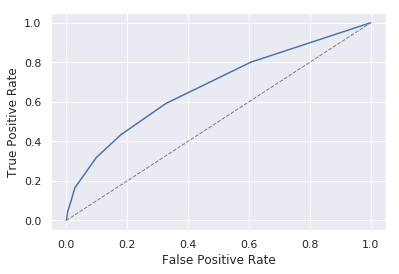

In [24]:
#draw ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Write function to call the model and predict a flight

In [27]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime
        
    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)
    
    #get date part
    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour
    
    origin = origin.upper()
    destination = destination.upper()
    
    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]
    return model.predict_proba(pd.DataFrame(input))[0][0]

In [28]:
# predict delay
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

0.6

In [29]:
# predict delay of same flight next day
predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL')

0.8

(0.0, 1.0)

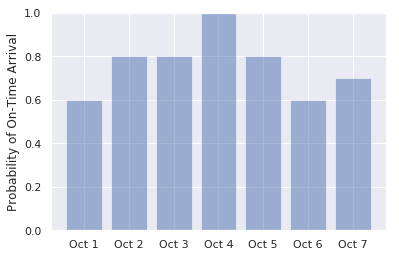

In [30]:
#predict delay for same flight a whole week
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

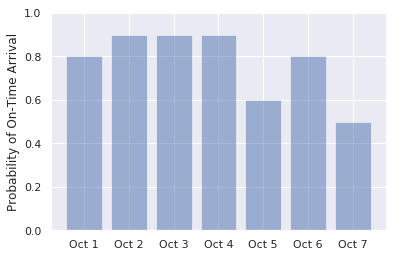

In [31]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('10/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('11/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('12/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('13/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('14/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('15/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('16/04/2018 13:00:00', 'JFK', 'MSP'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))